# Loading Data, Computing Metrics

Install Datasets library

In [ ]:
!pip install datasets transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 13.5 MB/s eta 0:00:00


The STS Benchmark is a compilation of English language datasets utilized in the STS tasks of SemEval competitions that took place from 2012 to 2017. The dataset selection covers various text genres, including image captions, news headlines, and user forums. [ref](http://ixa2.si.ehu.eus/stswiki/index.php/STSbenchmark)

Loading dataset and Metric

In [ ]:
from datasets import load_dataset, load_metric
import numpy as np

In [ ]:
task = "stsb"

In [ ]:
dataset = load_dataset("glue", task)
metric = load_metric('glue', task)

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/stsb/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-4-c91d69005843>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('glue', task)


View Dataset

In [ ]:
print("Sample from the train, validation and test dataset:")
# Train Dataset
print("Train Sample",dataset["train"][0])
# Valid Dataset
print("Validation Sample",dataset["validation"][0])
# Test Dataset
# Label of test set is -1
print("Test Sample",dataset["test"][0])

print("\nSamples in dataset:")
# Train Dataset
print("Train Sample",len(dataset["train"]))
# Valid Dataset
print("Validation Sample",len(dataset["validation"]))
# Test Dataset
print("Test Sample",len(dataset["test"]))

Sample from the train, validation and test dataset:
Train Sample {'sentence1': 'A plane is taking off.', 'sentence2': 'An air plane is taking off.', 'label': 5.0, 'idx': 0}
Validation Sample {'sentence1': 'A man with a hard hat is dancing.', 'sentence2': 'A man wearing a hard hat is dancing.', 'label': 5.0, 'idx': 0}
Test Sample {'sentence1': 'A girl is styling her hair.', 'sentence2': 'A girl is brushing her hair.', 'label': -1.0, 'idx': 0}

Samples in dataset:
Train Sample 5749
Validation Sample 1500
Test Sample 1379


In [ ]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))


In [ ]:
show_random_elements(dataset["train"])

Compute Pearson correlation coefficient and Spearman's rank correlation coefficient

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
import numpy as np

# Predictions and labels between 0 and 5
fake_preds = np.random.randint(0, 6, size=(64,))
fake_labels = np.random.randint(0, 6, size=(64,))
metric.compute(predictions=fake_preds, references=fake_labels)

{'pearson': 0.12229265381751847, 'spearmanr': 0.11092224541027856}

# Experiments

## Early interaction using BERT tiny
EarlyInteraction.png

### Finetune a [BERT-tiny](https://huggingface.co/prajjwal1/bert-tiny) model on STSB train set and report scores on the validation set.

In [ ]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset, load_metric


In [ ]:
task = "stsb"
dataset = load_dataset("glue", task)
metric = load_metric('glue', task)

In [ ]:
model_checkpoint = "prajjwal1/bert-tiny"
batch_size = 16

In [ ]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["sentence1"], examples["sentence2"],  padding = "longest", truncation=True,     return_tensors="pt" )

In [ ]:
preprocess_function(dataset['train'][:5])

In [ ]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
num_labels  = 1
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

In [ ]:
metric_name = "pearson"


In [ ]:
metric_name = "pearson" if task == "stsb" else "matthews_correlation" if task == "cola" else "accuracy"
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=100,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    save_total_limit = 1,
)

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
! pip install optuna

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)


In [ ]:
trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
train_dataset = encoded_dataset["train"].shard(index=1, num_shards=10) 


In [ ]:
best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")


In [ ]:
best_run

In [ ]:

best_run

for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

trainer.train()

## Dynamic Time Warping (DTW) without crossings using cosine simialrity/ euclidean distance

Given a pair of sentences, return optimal map between tokens of two sentences. Should handle degenerate solutions.

In [ ]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel

# Load the BERT-tiny model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('prajjwal1/bert-tiny')
model = AutoModel.from_pretrained('prajjwal1/bert-tiny')

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Encode a sentence into a matrix of BERT-tiny embeddings
def encode_sentence(sentence):
    input_ids = tokenizer(sentence, return_tensors="pt" )
    with torch.no_grad():
        outputs = model(**input_ids)
        embeddings = outputs.last_hidden_state.squeeze(0)
    return embeddings.numpy()

# Compute the distance between two embeddings using cosine similarity
def cosine_similarity(x, y):
    sim = np.zeros((x.shape[0]-2, y.shape[0]-2))
    for i in range(sim.shape[0]):
      for j in range(sim.shape[1]):
        dt = np.dot(x[i+1], y[j+1]) 
        norm_x = np.linalg.norm(x[i+1])
        norm_y = np.linalg.norm(y[j+1])
        sim[i,j] = dt/(norm_x*norm_y)
    return sim

def compute_cost_matrix(sentence1, sentence2):
    embeddings1 = encode_sentence(sentence1)
    embeddings2 = encode_sentence(sentence2)
    sim_matrix = cosine_similarity(embeddings1, embeddings2)
    return sim_matrix

In [ ]:
# Perform DTW with a non-crossing map that can handle degenerate solutions
def dtw(sentence1, sentence2):
    sim_matrix = compute_cost_matrix(sentence1, sentence2)
    n = sim_matrix.shape[0]
    m = sim_matrix.shape[1]
    DTW = np.zeros((n+1, m+1))
    alignment = np.zeros((n+1,m+1), dtype=int)

    for i in range(1, n+1):
        for j in range(1, m+1):
            s = sim_matrix[i-1,j-1]
            if ((DTW[i-1,j-1]+s > DTW[i,j-1]) and (DTW[i-1,j-1]+s > DTW[i-1,j])):
              DTW[i,j] = DTW[i-1,j-1] + s
              alignment[i,j] = j
            elif DTW[i-1,j] > DTW[i,j-1]:
              DTW[i,j] = DTW[i-1,j]
              alignment[i,j] = -1
            else:
              DTW[i,j] = DTW[i,j-1]
              alignment[i,j] = alignment[i,j-1]

    return DTW, alignment
# def dtw(sentence1, sentence2):
#     s = compute_cost_matrix(sentence1, sentence2) 
#     print(s.shape)
#     I = s.shape[0]
#     J = s.shape[1]
#     P = np.zeros((I, J))
#     K = np.empty((I, J))
#     M = np.zeros((I, J))

#     P[:,0] = s[:,0]
#     K[:,0] = np.nan

#     for j in range(J):
#         max_val = -np.inf
#         ptr = np.nan
#         P[0,j] = s[0,j]
#         K[0,j] = 0
#         for i in range(1, I):
#             if P[i-1,j-1] > max_val:
#                 max_val = P[i-1,j-1]
#                 ptr = i-1
#             val = max(0, s[i,j])
#             if val > 0:
#                 M[i,j] = 1
#             else:
#                 M[i,j] = 0
#             P[i,j] = max_val + val
#             K[i,j] = ptr

#     m = np.zeros(J)
#     k = np.zeros(J)
#     ii = np.argmax(P[:,J-1])
#     m[J-1] = ii
#     K[:,0] = ii

#     if M[ii][J - 1]:
#         k[J-1] = m[J-1]
#     else:
#         k[J-1] = np.nan
        
#     for j in range(J - 2, -1, -1):
#         m[j] = K[int(m[j+1]), j]
#         if M[int(m[j]), j]:
#             k[j] = m[j]
#         else:
#             k[j] = np.nan
#     return k, P

In [ ]:
s1 = "hello there ball cat in water"
s2 = "hello there water"

DTW, align = dtw(s1, s2)
print(DTW) # Scores DP
print(align) # Alignment MAP

[[0.         0.         0.         0.        ]
 [0.         0.96094447 0.96094447 0.96094447]
 [0.         0.96094447 1.88531309 1.88531309]
 [0.         0.96094447 1.88531309 2.65650636]
 [0.         0.96094447 1.88531309 2.65650636]
 [0.         0.96094447 1.88531309 2.65650636]
 [0.         0.96094447 1.88531309 2.65650636]]
[[ 0  0  0  0]
 [ 0  1  1  1]
 [ 0 -1  2  2]
 [ 0 -1 -1  3]
 [ 0 -1 -1 -1]
 [ 0 -1 -1 -1]
 [ 0 -1 -1 -1]]


## Dynamic Time Warping (DTW) using Tanh Calibration

### Dynamic Time Warping (DTW) without crossings

**Obtain Optimal non-crossing mapping**

---
Let the longer sentence (the sentence with more tokens) be s1 and shorter be s2 and i be an index of token from sentence 1 and j be an index of token from sentence 2.
We can use DP to keep track of score for each mapping i to j. Here we impose that each j must be mapped to i i.e. the tokens of the shorter sentence must be matched to a token of the longer one.

 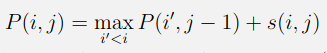

From the scores we can obtain the optimal mapping.


---


To allow some unmatched tokens on both sides, we can exclude the non negative similariy pairs during matching and let it not continute to the aggregate score.

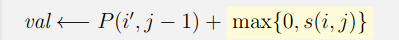


---

Any s(i, j) < 0 debars i from being a candidate for j. While cosine similarity can be positive or negative (in practice, negative cosine similarities are
somewhat rare), the fraction of cases where it is negative in an application may not be
consistent with the number of j we should aim to leave unassigned in the same application.
Also note that d(i, j) ≥ 0 always. If we instead use a notion of distance d(i, j), we need
to either switch the polarity of the dynamic programming recurrence, or use a decreasing
function of distance in the the recurrence. In either case, the check against 0 may become
trivial: no i may be rejected by j, or all is may be rejected. One solution (there may be
others) is to apply a smooth transformation of both s(i, j) and d(i, j) into a space that is
capable of being positive or negative with a distribution that optimizes for the end task,
say:

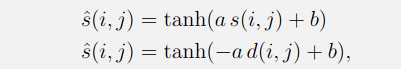

with additional parameters a, b to be trained.


Train a model to learn optimal a and b.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from tqdm.notebook import tqdm

def tensor_cosine(x, y, a, b):
    sim = torch.zeros((x.shape[0]-2, y.shape[0]-2))
    for i in range(sim.shape[0]):
      for j in range(sim.shape[1]):
        sim[i,j] = torch.dot(x[i+1], y[j+1])/(torch.linalg.norm(x[i+1])*torch.linalg.norm(y[j+1]))
    return torch.nn.functional.tanh(a*sim + b)

In [ ]:
# Non Crossing DTW for task three
def dtw_non_cross(embed1, embed2, a, b):
    s = tensor_cosine(embed1, embed2, a, b) 
    I = s.shape[0]
    J = s.shape[1]
    P = torch.zeros((I, J))

    for i in range(1, I):
        for j in range(1, J):
            if ((P[i-1,j-1]+s[i,j] > P[i,j-1]) and (P[i-1,j-1]+s[i,j] > P[i-1,j])):
              P[i,j] = P[i-1,j-1] + s[i,j]
            elif P[i-1,j] > P[i,j-1]:
              P[i,j] = P[i-1,j]
            else:
              P[i,j] = P[i,j-1]
    return P[I-1,J-1]/min(I,J)

In [ ]:
# Dataset preprocess
# Training on Half Dataset to Avoid RAM Overflow
train_data_len = 2500

train_data = {
    "embed1": [encode_sentence(dataset["train"]["sentence1"][i]) for i in range(train_data_len)],
    "embed2": [encode_sentence(dataset["train"]["sentence2"][i]) for i in range(train_data_len)],
    "label": [dataset["train"]["label"][i] for i in range(train_data_len)]
} 

val_data = {
    "embed1": [encode_sentence(dataset["validation"]["sentence1"][i]) for i in range(len(dataset["validation"]))],
    "embed2": [encode_sentence(dataset["validation"]["sentence2"][i]) for i in range(len(dataset["validation"]))],
    "label": [dataset["validation"]["label"][i] for i in range(len(dataset["validation"]))]
}

In [ ]:
a_non_cross = nn.Parameter(torch.tensor(1.0))
b_non_cross = nn.Parameter(torch.tensor(-0.5))

optimizer = optim.AdamW([a_non_cross, b_non_cross], lr=1e-3)

batch_size = 500
num_batches = (train_data_len + batch_size - 1) // batch_size
num_epochs = 5

for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    predicted_labels = []
    labels = []
    losses = []
    
    for i in range(num_batches):
        batch_start = i * batch_size
        batch_end = min((i+1)*batch_size, train_data_len)
        loss = 0
        pls = []
        ls = []

        for j in tqdm(range(batch_start, batch_end)):

            batch_embed1 = torch.tensor(train_data["embed1"][j])
            batch_embed2 = torch.tensor(train_data["embed2"][j])
            l = torch.tensor(train_data["label"][j]/2.5-1)
        
            pl = dtw_non_cross(batch_embed1, batch_embed2, a_non_cross, b_non_cross)
            loss = loss + (pl-l)**2
            pls.append(pl.item())
            ls.append(l.item())

        loss.backward()
        optimizer.step()

        predicted_labels.extend(pls)
        labels.extend(ls)
        losses.append((loss/batch_size).item())

    optimizer.zero_grad()
        
    metrics = metric.compute(predictions=np.array(predicted_labels), references=np.array(labels))
    print(f"Epoch {epoch}, Loss: {sum(losses)}, Metrics: {metrics}, a: {a_non_cross.item()}, b: {b_non_cross.item()}")
    

a_final = a_non_cross.item()
b_final = b_non_cross.item()

print(f"Final values for Non Crossing Mapping, of a: {a_final}, b: {b_final}")

Epoch 0


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0, Loss: 2.115538865327835, Metrics: {'pearson': 0.5575719684451462, 'spearmanr': 0.5416871647859092}, a: 0.99507737159729, b: -0.5048454403877258
Epoch 1


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1, Loss: 2.097359538078308, Metrics: {'pearson': 0.5585325084061652, 'spearmanr': 0.5424748264809041}, a: 0.9903260469436646, b: -0.5095118284225464
Epoch 2


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2, Loss: 2.0798675417900085, Metrics: {'pearson': 0.5594292732221887, 'spearmanr': 0.5432144670276114}, a: 0.9855821132659912, b: -0.51417076587677
Epoch 3


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3, Loss: 2.062887579202652, Metrics: {'pearson': 0.5603265918989436, 'spearmanr': 0.5439249945195959}, a: 0.9808638095855713, b: -0.5188040733337402
Epoch 4


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4, Loss: 2.0464802235364914, Metrics: {'pearson': 0.5612115050196814, 'spearmanr': 0.5446882729360353}, a: 0.9761821627616882, b: -0.5234010815620422
Final values for Non Crossing Mapping, of a: 0.9761821627616882, b: -0.5234010815620422


In [ ]:
a_non_cross, b_non_cross

(Parameter containing:
 tensor(0.9762, requires_grad=True),
 Parameter containing:
 tensor(-0.5234, requires_grad=True))

In [ ]:
# Checking Validation Dataset For Non Crossing
predicted_labels = []
labels = []
val_len = len(val_data["embed1"])
loss = 0

for i in tqdm(range(val_len)):
    emb1 = torch.tensor(val_data["embed1"][i])
    emb2 = torch.tensor(val_data["embed2"][i])
    l = torch.tensor(val_data["label"][i]/2.5-1)

    pl = dtw_non_cross(emb1, emb2, a_non_cross, b_non_cross)
    loss = loss + (pl-l)**2

    predicted_labels.append(pl.item())
    labels.append(l.item())
    
metrics = metric.compute(predictions=np.array(predicted_labels), references=np.array(labels))
print()
print(f"Loss: {loss.item()/val_len}, Metrics: {metrics}, a: {a_non_cross.item()}, b: {b_non_cross.item()}")

  0%|          | 0/1500 [00:00<?, ?it/s]


Loss: 0.3731934407552083, Metrics: {'pearson': 0.6014639921397058, 'spearmanr': 0.601540424026264}, a: 0.9761821627616882, b: -0.5234010815620422


### Dynamic Time Warping (DTW) with crossings

Scoring cross mappings should be easy.


Train a model to learn optimal a and b.

In [ ]:
def dtw_cross(embed1, embed2, a, b):
    s = tensor_cosine(embed1, embed2, a, b) 
    I = s.shape[0]
    J = s.shape[1]
    score = torch.tensor(0)

    for i in range(I):
        for j in range(J):
            if s[i,j] > 0:
                score = score + s[i,j]
    
    return (score/min(I,J))

In [ ]:
a_cross = nn.Parameter(torch.tensor(1.0))
b_cross = nn.Parameter(torch.tensor(-0.5))

optimizer = optim.AdamW([a_cross, b_cross], lr=1e-3)

batch_size = 500
num_batches = (train_data_len + batch_size - 1) // batch_size
num_epochs = 5

for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    predicted_labels = []
    labels = []
    losses = []
    
    for i in range(num_batches):
        batch_start = i * batch_size
        batch_end = min((i+1)*batch_size, train_data_len)
        loss = 0
        pls = []
        ls = []

        for j in tqdm(range(batch_start, batch_end)):

            batch_embed1 = torch.tensor(train_data["embed1"][j])
            batch_embed2 = torch.tensor(train_data["embed2"][j])
            l = torch.tensor(train_data["label"][j]/2.5-1)
        
            pl = dtw_cross(batch_embed1, batch_embed2, a_cross, b_cross)
            loss = loss + (pl-l)**2
            pls.append(pl.item())
            ls.append(l.item())

        loss.backward()
        optimizer.step()

        predicted_labels.extend(pls)
        labels.extend(ls)
        losses.append((loss/batch_size).item())

    optimizer.zero_grad()
        
    metrics = metric.compute(predictions=np.array(predicted_labels), references=np.array(labels))
    print(f"Epoch {epoch}, Loss: {sum(losses)}, Metrics: {metrics}, a: {a_cross.item()}, b: {b_cross.item()}")
    

a_final = a_cross.item()
b_final = b_cross.item()

print(f"Final values For Crossing Map, of a: {a_final}, b: {b_final}")

Epoch 0


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0, Loss: 14.282108306884766, Metrics: {'pearson': 0.49608515569356476, 'spearmanr': 0.5115246439978007}, a: 0.995182454586029, b: -0.5047422647476196
Epoch 1


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1, Loss: 13.111116647720337, Metrics: {'pearson': 0.5015617160851438, 'spearmanr': 0.5169552333933785}, a: 0.9907674789428711, b: -0.5090774893760681
Epoch 2


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2, Loss: 12.03724479675293, Metrics: {'pearson': 0.5068848508889849, 'spearmanr': 0.5221124464564028}, a: 0.9863687753677368, b: -0.513394296169281
Epoch 3


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3, Loss: 11.03557276725769, Metrics: {'pearson': 0.5119143890079945, 'spearmanr': 0.5270715088421382}, a: 0.9820263385772705, b: -0.5176514387130737
Epoch 4


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4, Loss: 10.109965562820435, Metrics: {'pearson': 0.5165883836248225, 'spearmanr': 0.5317463056322428}, a: 0.9777642488479614, b: -0.5218238234519958
Final values For Crossing Map, of a: 0.9777642488479614, b: -0.5218238234519958


In [ ]:
a_cross, b_cross

(Parameter containing:
 tensor(0.9778, requires_grad=True),
 Parameter containing:
 tensor(-0.5218, requires_grad=True))

In [ ]:
# Checking Validation Dataset For Non Crossing
predicted_labels = []
labels = []
val_len = len(val_data["embed1"])
loss = 0

for i in tqdm(range(val_len)):
    emb1 = torch.tensor(val_data["embed1"][i])
    emb2 = torch.tensor(val_data["embed2"][i])
    l = torch.tensor(val_data["label"][i]/2.5-1)

    pl = dtw_cross(emb1, emb2, a_cross, b_cross)
    loss = loss + (pl-l)**2

    predicted_labels.append(pl.item())
    labels.append(l.item())
    
metrics = metric.compute(predictions=np.array(predicted_labels), references=np.array(labels))
print()
print(f"Loss: {loss.item()/val_len}, Metrics: {metrics}, a: {a_cross.item()}, b: {b_cross.item()}")

  0%|          | 0/1500 [00:00<?, ?it/s]


Loss: 2.137397623697917, Metrics: {'pearson': 0.537575190334007, 'spearmanr': 0.5932068631150422}, a: 0.9777642488479614, b: -0.5218238234519958


# Results